
<!-- Título -->
  <h1 style="text-align:center; font-family: Segoe UI, Roboto, Arial, sans-serif; 
             font-weight:800; font-size:2.4rem; letter-spacing:-0.02em; 
             color:#FFFF00; margin:.4rem 0 .6rem;">
    DETECTION OF EYE SOCKETS
  </h1>

### **A) Import libaries**

In [ ]:
import os
import numpy as np
import pydicom
import matplotlib.pyplot as plt
from ipywidgets import interact, IntSlider, fixed
import cv2
from skimage import exposure

plt.rcParams['figure.figsize'] = [6,6]  #Set default figure size for matplotlib


### **B) DICOMS reading function**

In [24]:
def read_dicom(path):
    archives = [f for f in os.listdir(path) if f.endswith('.dcm')]
    dicoms = [pydicom.dcmread(os.path.join(path, f)) for f in archives]
    dicoms.sort(key=lambda x: int(getattr(x,"InstanceNumber",0)))
    return dicoms

Path = r"C:\Users\asus\OneDrive - UNIVERSIDAD INDUSTRIAL DE SANTANDER\Documents\CPS\Detección de cuencas oculares\25"

list_dicoms = read_dicom(Path)

print(f"{len(list_dicoms)} DICOM files were uploaded!")

288 DICOM files were uploaded!


### **C) Checking for cuts**

In [38]:
import pydicom
import pydicom.pixel_data_handlers as pdh

print("Is Pillow avaliable?:", pdh.pillow_handler.is_available())
print("Is GDCM avaliable?:", pdh.gdcm_handler.is_available())
print("Is pylibjpeg avaliable?:", pdh.pylibjpeg_handler.is_available())


Is Pillow avaliable?: True
Is GDCM avaliable?: False
Is pylibjpeg avaliable?: True


### **D) Function to display a cut**

Volumen: (288, 512, 512)


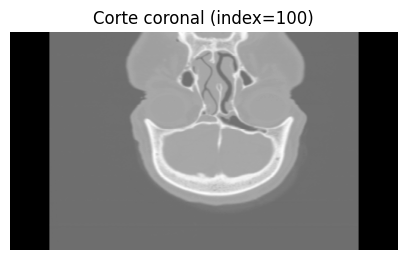

In [40]:
# 1. Construir el volumen 3D a partir de los cortes axiales
def build_volume(dicoms):
    slices = [d.pixel_array for d in dicoms]
    volume = np.stack(slices, axis=0)  # (num_slices, height, width)
    return volume

volume = build_volume(list_dicoms)
print("Volumen:", volume.shape)  # Ej: (250, 512, 512)

# 2. Mostrar únicamente la vista coronal
def show_coronal(volume, index):
    coronal = volume[:, index, :]
    plt.figure(figsize=(5, 5))
    plt.imshow(coronal, cmap="gray")
    plt.title(f"Corte coronal (index={index})")
    plt.axis("off")
    plt.show()

# Ejemplo: mostrar un corte coronal
show_coronal(volume, 100)
